#Compare classification models' prediction whether a job is fraud or not using its description

In [15]:
from google.colab import files

In [20]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib
from nltk.tokenize import RegexpTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
import nltk
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
#from imblearn import SMOTE
from sklearn.preprocessing import LabelEncoder


nltk.download('stopwords')


stop_words = set(stopwords.words("english"))
default_stemmer = PorterStemmer()
default_stopwords = stopwords.words('english')
default_tokenizer=RegexpTokenizer(r"\w+")

df = pd.read_csv("fake_job_postings.csv")
df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [2]:
df.info() 
#categorical features: telecommuting, has_company_logo, has_questions, fraudulent (target)
#text data: title, location, department, salary_range, company_profile, description, requirements, benefits, required_experience,required_education, industry, function

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [3]:
print('\n',df.isnull().sum()/len(df))
#drop all features with missing values % greather than 50%
print("\nDropped features: department, salary_range, job_id, benefits since\n is_null().sum()/len(df) >= 0.5\n")
df = df.drop('department',axis=1)
df = df.drop('salary_range',axis=1)
df = df.drop('job_id',axis = 1)
df = df.drop('benefits', axis = 1)
df = df.replace(np.nan, '', regex=True)
print('\n',df.isnull().sum()/len(df))


 job_id                 0.000000
title                  0.000000
location               0.019351
department             0.645805
salary_range           0.839597
company_profile        0.185011
description            0.000056
requirements           0.150727
benefits               0.403244
telecommuting          0.000000
has_company_logo       0.000000
has_questions          0.000000
employment_type        0.194128
required_experience    0.394295
required_education     0.453300
industry               0.274217
function               0.361018
fraudulent             0.000000
dtype: float64

Dropped features: department, salary_range, job_id, benefits since
 is_null().sum()/len(df) >= 0.5


 title                  0.0
location               0.0
company_profile        0.0
description            0.0
requirements           0.0
telecommuting          0.0
has_company_logo       0.0
has_questions          0.0
employment_type        0.0
required_experience    0.0
required_education     0.0
industr

In [4]:
df['fraudulent'].value_counts()
#Data is imbalanced

0    17014
1      866
Name: fraudulent, dtype: int64

In [5]:
#combine all the text data into one column
df['full_text'] = df['title'] + ' ' + df['location'] + ' ' + df['company_profile'] + ' ' + df['description'] + ' ' +  df['requirements'] + ' ' + df['employment_type'] + ' ' +  df['required_education'] + ' ' + df['required_experience'] + ' '+ df['industry'] + ' ' +  df['function']
#remove the joined text columns from the dataset
df.drop(['title','location','company_profile', 'industry','function','description','requirements', 'employment_type', 'required_education', 'required_experience'], axis=1, inplace=True)
df.columns

Index(['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent',
       'full_text'],
      dtype='object')

In [6]:
df.head()

,telecommuting,has_company_logo,has_questions,fraudulent,full_text
0,0,1,0,0,"Marketing Intern US, NY, New York We're Food52..."
1,0,1,0,0,"Customer Service - Cloud Video Production NZ, ..."
2,0,1,0,0,"Commissioning Machinery Assistant (CMA) US, IA..."
3,0,1,0,0,"Account Executive - Washington DC US, DC, Wash..."
4,0,1,1,0,"Bill Review Manager US, FL, Fort Worth SpotSou..."


In [7]:
def clean_text(text, ):
        if text is not None:
                text = re.sub(r'[0-9]+','',text)
                text =  text.lower()
                text = re.sub('re:', '', text)
                text = re.sub('-', '', text)
                text = re.sub('_', '', text)
                text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
                text = re.sub(r'\S*@\S*\s?', '', text, flags=re.MULTILINE)
        # Remove text between square brackets
                text =re.sub('\[[^]]*\]', '', text)
        # removes punctuation
                text = re.sub(r'[^\w\s]','',text)
                text = re.sub(r'\n',' ',text)
                text = re.sub(r'[0-9]+','',text)
                #text = re.sub(r'[0-9]+','',text)
        # strip html 
                p = re.compile(r'<.*?>')
                text = re.sub(r"\'ve", " have ", text)
                text = re.sub(r"can't", "cannot ", text)
                text = re.sub(r"n't", " not ", text)
                text = re.sub(r"I'm", "I am", text)
                text = re.sub(r" m ", " am ", text)
                text = re.sub(r"\'re", " are ", text)
                text = re.sub(r"\'d", " would ", text)
                text = re.sub(r"\'ll", " will ", text)
        
                text = p.sub('', text)

        def tokenize_text(text,tokenizer=default_tokenizer):
            token = default_tokenizer.tokenize(text)
            return token
        
        def remove_stopwords(text, stop_words=default_stopwords):
            tokens = [w for w in tokenize_text(text) if w not in stop_words]
            return ' '.join(tokens)

        def stem_text(text, stemmer=default_stemmer):
            tokens = tokenize_text(text)
            return ' '.join([stemmer.stem(t) for t in tokens])

        text = stem_text(text) # stemming
        text = remove_stopwords(text) # remove stopwords

        return text
df['full_text'] = df['full_text'].apply(clean_text)
df['full_text'].head()

0    market intern us ny new york food weve creat g...
1    custom servic cloud video product nz auckland ...
2    commiss machineri assist cma us ia wever valor...
3    account execut washington dc us dc washington ...
4    bill review manag us fl fort worth spotsourc s...
Name: full_text, dtype: object

In [16]:
df.to_csv('combined_text.csv')
files.download('combined_text.csv')
df.head()
df1 = df.copy()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
df = pd.read_csv('combined_text.csv')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf = TfidfVectorizer(max_features = 200)
cv = CountVectorizer(max_features = 200)

text_num_tfidf = tfidf.fit_transform(df['full_text'])
text_num_cv = cv.fit_transform(df['full_text'])

df_tfidf = pd.DataFrame(text_num_tfidf.toarray(), columns=tfidf.get_feature_names())
df_cv = pd.DataFrame(text_num_cv.toarray(), columns=cv.get_feature_names())

df.drop(["full_text"], axis=1, inplace=True)
main_df_tfidf = pd.concat([df_tfidf,df], axis=1)
main_df_cv = pd.concat([df_cv,df], axis=1)

In [19]:
main_df_cv

,abil,abl,account,across,activ,administr,agenc,also,amp,analyt,andor,ani,appli,applic,area,assist,associ,avail,bachelor,base,best,brand,build,busi,candid,care,career,chang,client,close,collabor,commun,compani,comput,consult,content,continu,contract,creat,creativ,...,softwar,solut,staff,startup,strategi,strong,success,support,system,take,talent,team,technic,technolog,test,thi,time,tool,train,understand,us,use,user,valu,want,way,web,websit,well,within,work,world,written,year,youll,Unnamed: 0,telecommuting,has_company_logo,has_questions,fraudulent
0,0,0,0,0,0,2,0,1,1,0,1,2,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,2,1,0,0,3,0,0,1,0,...,0,0,1,1,0,0,0,2,1,0,1,2,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,2,0,0,4,0,0,0,0,0,0,1,0,0
1,0,1,1,0,0,1,2,0,2,0,1,0,0,1,0,0,0,0,0,1,0,5,0,3,0,0,0,0,3,0,0,4,2,1,0,2,0,0,0,0,...,1,0,0,1,0,0,5,0,1,1,2,4,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,0,0,6,9,0,0,0,1,0,1,0,0
2,0,0,0,1,5,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,1,0,3,0,0,0,3,0,0,0,0,1,0,0,...,0,1,0,0,0,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,2,0,0,0,0,2,0,1,0,0
3,1,0,11,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,2,0,0,0,1,9,0,0,0,2,0,0,1,1,1,1,0,0,0,0,0,0,...,1,2,0,0,3,1,1,0,3,1,0,4,0,4,0,0,0,0,0,4,1,0,0,1,0,0,0,0,0,2,2,4,1,2,0,3,0,1,0,0
4,0,1,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,2,0,2,0,0,1,0,2,4,0,1,0,0,1,2,0,3,0,0,0,1,0,...,0,2,1,0,0,0,2,0,0,0,5,1,0,0,0,0,1,0,1,2,1,0,0,0,0,0,0,0,1,0,3,0,0,1,0,4,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,1,0,3,3,0,1,0,1,4,0,0,0,0,0,1,0,1,0,0,1,1,1,3,3,0,2,0,1,0,0,1,1,4,1,0,0,0,0,0,0,...,3,0,0,1,0,3,4,1,0,3,2,5,0,0,0,4,1,0,1,1,2,0,0,0,5,1,1,1,0,1,11,2,0,0,4,17875,0,1,1,0
17876,2,1,12,0,0,2,0,1,1,0,0,1,0,1,0,2,0,0,1,2,0,2,0,0,2,0,0,0,3,0,0,1,2,1,0,0,0,0,2,0,...,0,1,0,0,1,1,1,1,0,1,0,1,0,1,0,1,2,3,0,1,3,1,0,0,1,0,1,0,1,1,5,0,0,2,0,17876,0,1,1,0
17877,0,1,2,0,0,0,0,0,0,2,0,0,2,0,0,0,0,1,0,0,0,0,0,1,1,0,0,3,1,1,0,2,2,1,0,0,0,1,0,0,...,0,1,2,0,1,0,0,4,1,0,0,2,1,0,0,0,2,1,0,0,3,0,0,0,0,0,0,3,0,0,3,0,0,2,0,17877,0,0,0,0
17878,0,2,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,2,...,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,17878,0,0,1,0


In [ ]:
main_df_tfidf.to_csv('/Users/vasudha/Desktop/Semester 6/CIS 3715/Project/tfidf.csv')
main_df_cv.to_csv('/Users/vasudha/Desktop/Semester 6/CIS 3715/Project/cv.csv')
print('done')

done


In [ ]:
x_tfidf = main_df_tfidf.drop('fraudulent', axis = 1)
y_tfidf = main_df_tfidf['fraudulent']
print(x_tfidf.shape)
print(y_tfidf.shape)
x_cv = main_df_cv.drop('fraudulent', axis = 1)
y_cv = main_df_cv['fraudulent']
print(x_cv.shape)
print(y_cv.shape)

(17880, 204)
(17880,)
(17880, 204)
(17880,)


<AxesSubplot:>

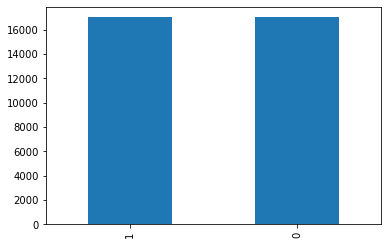

In [ ]:
#balance the data
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 15)
new_x_tfidf, new_y_tfidf = sm.fit_resample(x_tfidf,y_tfidf)
new_y_tfidf.value_counts().plot(kind = 'bar')

sm = SMOTE(random_state = 15)
new_x_cv, new_y_cv = sm.fit_resample(x_cv,y_cv)
new_y_cv.value_counts().plot(kind = 'bar')

In [ ]:
#split the data
x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(new_x_tfidf,new_y_tfidf,test_size = .2)
x_train_cv, x_test_cv, y_train_cv, y_test_cv = train_test_split(new_x_cv,new_y_cv,test_size = .2)



In [ ]:
print(x_train_tfidf.shape)
print(x_test_tfidf.shape)
print(y_train_tfidf.shape)
print(y_test_tfidf.shape)

(27222, 204)
(6806, 204)
(27222,)
(6806,)


Tfidf Logistics Regression:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      3442
           1       0.90      0.93      0.92      3364

    accuracy                           0.92      6806
   macro avg       0.92      0.92      0.92      6806
weighted avg       0.92      0.92      0.92      6806



<AxesSubplot:>

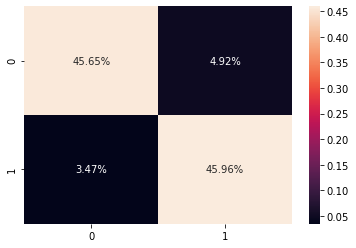

In [ ]:
#logistic regression tfidf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import seaborn as sns
coeff = range(1, 10)
param_grid = {'C':coeff, 'penalty':["l1","l2"]}
lr = LogisticRegression(solver = 'liblinear')
grid_lr = GridSearchCV(lr, param_grid, cv = 10)
grid_lr.fit(x_train_tfidf,y_train_tfidf)

lrf_tfidf = LogisticRegression(C=grid_lr.best_params_['C'], penalty = grid_lr.best_params_['penalty'],solver = 'liblinear')
lrf_tfidf.fit(x_train_tfidf, y_train_tfidf)
y_pred_tfidf = lrf_tfidf.predict(x_test_tfidf)
cm = confusion_matrix(y_test_tfidf, y_pred_tfidf)
print("Tfidf Logistics Regression:")
print(classification_report(y_test_tfidf,y_pred_tfidf))
sns.heatmap(cm/np.sum(cm),annot=True, fmt='.2%')

BOW Logistics Regression:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      3330
           1       0.94      0.96      0.95      3476

    accuracy                           0.95      6806
   macro avg       0.95      0.95      0.95      6806
weighted avg       0.95      0.95      0.95      6806



<AxesSubplot:>

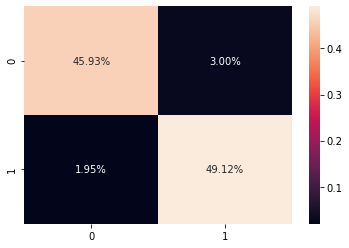

In [ ]:
#logistic regression bow
coeff = range(1, 10)

param_grid = {'C':coeff, 'penalty':["l1","l2"]}
lr = LogisticRegression(solver = 'liblinear')
grid_lr = GridSearchCV(lr, param_grid, cv = 10)
grid_lr.fit(x_train_cv,y_train_cv)
lrf_cv = LogisticRegression(C=grid_lr.best_params_['C'], penalty = grid_lr.best_params_['penalty'],solver = 'liblinear')
lrf_cv.fit(x_train_cv, y_train_cv)

y_pred_cv = lrf_cv.predict(x_test_cv)
print("BOW Logistics Regression:")
print(classification_report(y_test_cv,y_pred_cv))
cm = confusion_matrix(y_test_cv,y_pred_cv)
sns.heatmap(cm/np.sum(cm),annot=True, fmt='.2%')

TFIDF KNN:
With 2 as K
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      3442
           1       0.88      0.81      0.85      3364

    accuracy                           0.85      6806
   macro avg       0.86      0.85      0.85      6806
weighted avg       0.86      0.85      0.85      6806



<AxesSubplot:>

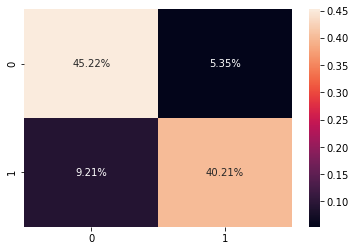

In [ ]:
#knn tfidf
from sklearn.neighbors import KNeighborsClassifier
k = range(1,8)
param_grid = dict(n_neighbors = k)
knn = KNeighborsClassifier(n_neighbors=1)
grid = GridSearchCV(knn, param_grid, cv = 10)
grid.fit(x_train_tfidf, y_train_tfidf)

knn_tfidf = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])
knn_tfidf.fit(x_train_tfidf,y_train_tfidf)
y_test_pred = knn_tfidf.predict(x_test_tfidf)
print("TFIDF KNN:")
print("With " + str(grid.best_params_['n_neighbors']) + " as K")
print(classification_report(y_test_tfidf,y_test_pred))
cm = confusion_matrix(y_test_tfidf, y_test_pred)
sns.heatmap(cm/np.sum(cm),annot=True, fmt='.2%')


BOW KNN:
With 2 as K
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      3330
           1       0.87      0.97      0.92      3476

    accuracy                           0.91      6806
   macro avg       0.92      0.91      0.91      6806
weighted avg       0.92      0.91      0.91      6806



<AxesSubplot:>

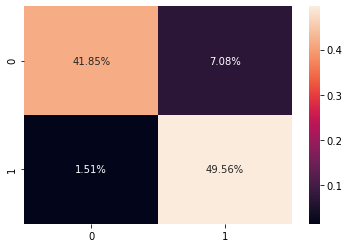

In [ ]:
#knn bow
param_grid = dict(n_neighbors = k)
knn = KNeighborsClassifier(n_neighbors=1)
grid = GridSearchCV(knn, param_grid, cv = 10)
grid.fit(x_train_cv, y_train_cv)

knn_cv = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])
knn_cv.fit(x_train_cv,y_train_cv)
y_test_pred = knn_cv.predict(x_test_cv)
print("BOW KNN:")
print("With " + str(grid.best_params_['n_neighbors']) + " as K")
print(classification_report(y_test_cv,y_test_pred))
cm = confusion_matrix(y_test_cv, y_test_pred)
sns.heatmap(cm/np.sum(cm),annot=True, fmt='.2%')

/Users/vasudha/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


TFIDF MLP:
              precision    recall  f1-score   support

           0       0.99      0.03      0.06      3442
           1       0.50      1.00      0.67      3364

    accuracy                           0.51      6806
   macro avg       0.75      0.51      0.36      6806
weighted avg       0.75      0.51      0.36      6806



/Users/vasudha/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


<AxesSubplot:>

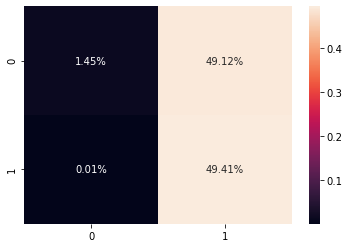

In [ ]:
#mlp?
from sklearn.neural_network import MLPClassifier
mlp_tfidf = MLPClassifier(max_iter=1, random_state = 15)
parameter_grid = {
    'hidden_layer_sizes': [(10,),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
grid_mlp_tfidf = GridSearchCV(mlp_tfidf,parameter_grid, n_jobs = -1, cv = 2)
grid_mlp_tfidf.fit(x_train_tfidf, y_train_tfidf)
mlp_tfidf_1 = MLPClassifier(max_iter = 1,hidden_layer_sizes = grid_mlp_tfidf.best_params_['hidden_layer_sizes'], activation = grid_mlp_tfidf.best_params_['activation'], solver = grid_mlp_tfidf.best_params_['solver'], alpha = grid_mlp_tfidf.best_params_['alpha'], learning_rate = grid_mlp_tfidf.best_params_['learning_rate'] )
mlp_tfidf_1.fit(x_train_tfidf, y_train_tfidf)
y_test_pred = mlp_tfidf_1.predict(x_test_tfidf)
print("TFIDF MLP:")
print(classification_report(y_test_tfidf,y_test_pred))
cm = confusion_matrix(y_test_tfidf, y_test_pred)
sns.heatmap(cm/np.sum(cm),annot=True, fmt='.2%')



/Users/vasudha/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


BOW MLP:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67      3330
           1       0.68      0.68      0.68      3476

    accuracy                           0.68      6806
   macro avg       0.68      0.68      0.68      6806
weighted avg       0.68      0.68      0.68      6806



/Users/vasudha/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


<AxesSubplot:>

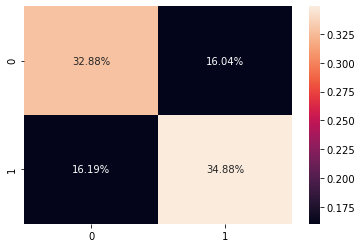

In [ ]:
mlp_cv = MLPClassifier(max_iter=1, random_state = 15)
parameter_grid = {
    'hidden_layer_sizes': [(10,),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
grid_mlp_cv = GridSearchCV(mlp_cv,parameter_grid, n_jobs = -1, cv = 2)
grid_mlp_cv.fit(x_train_cv, y_train_cv)
mlp_cv_1 = MLPClassifier(max_iter = 1,hidden_layer_sizes = grid_mlp_cv.best_params_['hidden_layer_sizes'], activation = grid_mlp_cv.best_params_['activation'], solver = grid_mlp_cv.best_params_['solver'], alpha = grid_mlp_cv.best_params_['alpha'], learning_rate = grid_mlp_cv.best_params_['learning_rate'] )
mlp_cv_1.fit(x_train_cv, y_train_cv)
y_test_pred = mlp_cv_1.predict(x_test_cv)
print("BOW MLP:")
print(classification_report(y_test_cv,y_test_pred))
cm = confusion_matrix(y_test_cv, y_test_pred)
sns.heatmap(cm/np.sum(cm),annot=True, fmt='.2%')

TFIDF RFC:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3442
           1       0.99      0.99      0.99      3364

    accuracy                           0.99      6806
   macro avg       0.99      0.99      0.99      6806
weighted avg       0.99      0.99      0.99      6806



<AxesSubplot:>

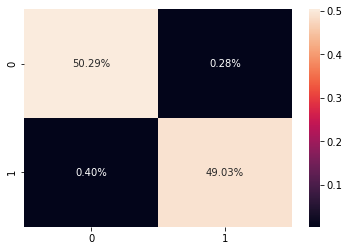

In [ ]:
#random forest classifier tfidf
from sklearn.ensemble import RandomForestClassifier
param_grid = { 
    'n_estimators': [5, 20, 25]
}
rf = RandomForestClassifier(criterion="entropy")
grid_rfc_tfidf = GridSearchCV(rf, param_grid, cv = 5)
grid_rfc_tfidf.fit(x_train_tfidf, y_train_tfidf)
rf_tfidf = RandomForestClassifier(criterion="entropy",n_estimators = grid_rfc_tfidf.best_params_['n_estimators'])
rf_tfidf.fit(x_train_tfidf, y_train_tfidf)
y_pred = rf_tfidf.predict(x_test_tfidf)
print("TFIDF RFC:")
print(classification_report(y_test_tfidf,y_pred))
cm = confusion_matrix(y_test_tfidf, y_pred)
sns.heatmap(cm/np.sum(cm),annot=True, fmt='.2%')



CV RFC:
              precision    recall  f1-score   support

           0       0.70      1.00      0.83      3330
           1       1.00      0.60      0.75      3476

    accuracy                           0.79      6806
   macro avg       0.85      0.80      0.79      6806
weighted avg       0.85      0.79      0.78      6806



<AxesSubplot:>

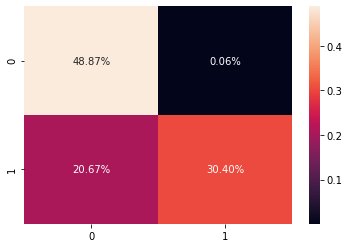

In [ ]:
#random forest classifier bow
param_grid = { 
    'n_estimators': [5, 20, 25]
}
rf = RandomForestClassifier(criterion="entropy")
grid_rfc_cv = GridSearchCV(rf, param_grid, cv = 5)
grid_rfc_cv.fit(x_train_cv, y_train_cv)
rf_cv = RandomForestClassifier(criterion="entropy",n_estimators = grid_rfc_cv.best_params_['n_estimators'])
rf_cv.fit(x_train_cv, y_train_cv)
y_pred = rf_tfidf.predict(x_test_cv)
print("CV RFC:")
print(classification_report(y_test_cv,y_pred))
cm = confusion_matrix(y_test_cv, y_pred)
sns.heatmap(cm/np.sum(cm),annot=True, fmt='.2%')

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3442
           1       0.98      0.98      0.98      3364

    accuracy                           0.98      6806
   macro avg       0.98      0.98      0.98      6806
weighted avg       0.98      0.98      0.98      6806



<AxesSubplot:>

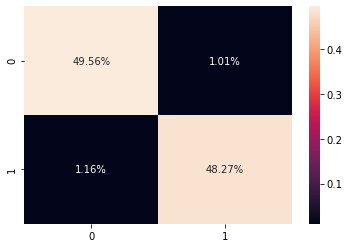

In [ ]:
from sklearn.ensemble import VotingClassifier
#voting classifier, hard, tfidf
voting_hard = VotingClassifier(estimators = [('RFC',rf_tfidf), ('Log Reg',lrf_tfidf), ('KNN', knn_tfidf)], voting = 'hard')
voting_hard.fit(x_train_tfidf, y_train_tfidf)
preds = voting_hard.predict(x_test_tfidf)
print(classification_report(y_test_tfidf,preds))
cm = confusion_matrix(y_test_tfidf, preds)
sns.heatmap(cm/np.sum(cm),annot=True, fmt='.2%')

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3442
           1       0.97      0.98      0.97      3364

    accuracy                           0.97      6806
   macro avg       0.97      0.97      0.97      6806
weighted avg       0.97      0.97      0.97      6806



<AxesSubplot:>

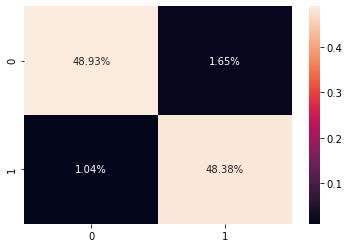

In [ ]:
voting_soft = VotingClassifier(estimators = [('RFC',rf_tfidf), ('Log Reg',lrf_tfidf), ('KNN', knn_tfidf)], voting = 'soft')
voting_soft.fit(x_train_tfidf, y_train_tfidf)
preds = voting_soft.predict(x_test_tfidf)
print(classification_report(y_test_tfidf,preds))
cm = confusion_matrix(y_test_tfidf, preds)
sns.heatmap(cm/np.sum(cm),annot=True, fmt='.2%')

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3330
           1       0.98      0.99      0.99      3476

    accuracy                           0.98      6806
   macro avg       0.98      0.98      0.98      6806
weighted avg       0.98      0.98      0.98      6806



<AxesSubplot:>

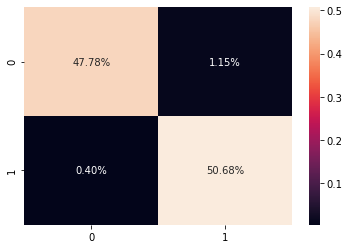

In [ ]:
voting_hard = VotingClassifier(estimators = [('RFC',rf_cv), ('Log Reg',lrf_cv), ('KNN', knn_cv)], voting = 'hard')
voting_hard.fit(x_train_cv, y_train_cv)
preds = voting_hard.predict(x_test_cv)
print(classification_report(y_test_cv,preds))
cm = confusion_matrix(y_test_cv, preds)
sns.heatmap(cm/np.sum(cm),annot=True, fmt='.2%')

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      3330
           1       0.97      1.00      0.98      3476

    accuracy                           0.98      6806
   macro avg       0.98      0.98      0.98      6806
weighted avg       0.98      0.98      0.98      6806



<AxesSubplot:>

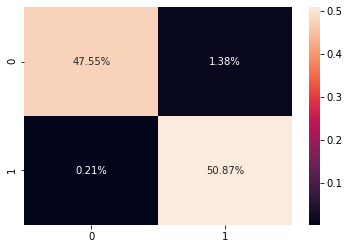

In [ ]:
#voting classifer, soft, cv
voting_soft = VotingClassifier(estimators = [('RFC',rf_cv), ('Log Reg',lrf_cv), ('KNN', knn_cv)], voting = 'soft')
voting_soft.fit(x_train_cv, y_train_cv)
preds = voting_soft.predict(x_test_cv)
print(classification_report(y_test_cv,preds))
cm = confusion_matrix(y_test_cv, preds)
sns.heatmap(cm/np.sum(cm),annot=True, fmt='.2%')